In [77]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, recall_score, accuracy_score
import optuna

%matplotlib inline

In [61]:
data = pd.read_csv("../../data/heart.csv")

## Do some EDA

In [16]:
profile_report = ProfileReport(data, title="Heart Disease profiling Report", explorative=True)

In [17]:
profile_report.config.variables.descriptions = {
    "age": "age in years",
    "sex": "1 = male; 0 = female",
    "cp": "chest pain type",
    "trestbps": "resting blood pressure (in mm Hg on admission to the hospital)",
    "chol": "serum cholestoral in mg/dl) - (needs to be less than 200 mg/dL)",
    "fbs": "fasting blood sugar > 120 mg/dl (1 = true; 0 = false) - (A fasting blood sugar level less than 100 mg/dL (5.6 mmol/L) is normal. A fasting blood sugar level from 100 to 125 mg/dL (5.6 to 6.9 mmol/L) is considered prediabetes. If it's 126 mg/dL (7 mmol/L) or higher on two separate tests, you have diabetes.",
    "restecg": "resting electrocardiographic results",
    "thalach": "maximum heart rate achieved",
    "exang": "exercise induced angina (1 = yes; 0 = no) - (Angina is chest pain or discomfort caused when your heart muscle doesn't get enough oxygen-rich blood.)",
    "oldpeak": "ST depression induced by exercise relative to rest",
    "slope": "the slope of the peak exercise ST segment",
    "ca": "number of major vessels (0-3) colored by flourosopy",
    "thal": "3 = normal; 6 = fixed defect; 7 = reversable defect",
    "target": "Value 0: < 50% diameter narrowing - Value 1: > 50% diameter narrowing"
}

### HTML report

In [18]:
profile_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Correlation plot

<AxesSubplot:>

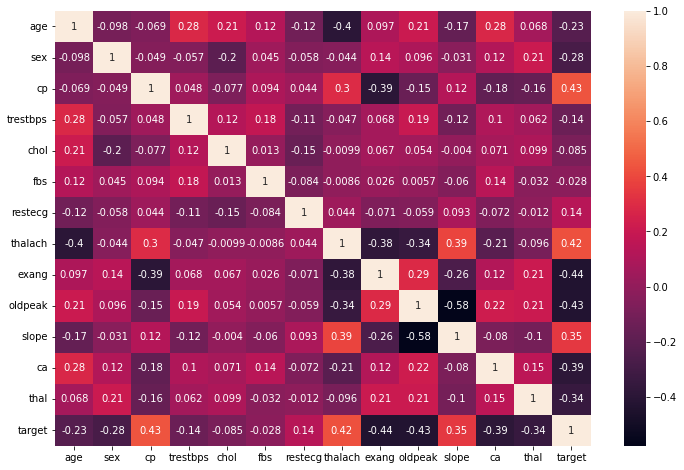

In [31]:
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot = True)

## Prepping data

In [62]:
print(f"data: {data.shape}")

data: (303, 14)


In [63]:
X = data.drop("target", axis=1)
y = data["target"]

In [64]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.1)

In [65]:
print(f"X train: {X_train.shape}, y train: {y_train.shape}")

X train: (272, 13), y train: (272,)


## Do hyperparameters tuning

### Optimize with Optuna

In [93]:
def objective(trial):
    loss = trial.suggest_categorical("loss", ["hinge", "squared_hinge", "modified_huber", "log"])
    learn_rate = trial.suggest_categorical("learning_rate", ["optimal", "adaptive"])
    penalty = trial.suggest_categorical("penalty", ["l1", "l2", "elasticnet"])
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2)
    l1_ratio = trial.suggest_float("l1_ratio", 0, 1)
    eta0 = trial.suggest_float("eta0", 1e-6, 1e-2)

    # if penalty == "elasticnet":
    #     l1_ratio = trial.suggest_float(0, 1)
    # else:
    #     l1_ratio = None

    clf = SGDClassifier(loss=loss, penalty=penalty, alpha=alpha, l1_ratio=l1_ratio, learning_rate=learn_rate, eta0=eta0)

    scores = cross_val_score(clf, X, y, n_jobs=-1, cv=5, scoring="f1")

    return scores.mean()

In [94]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=5000)

[I 2021-10-29 23:17:37,812] A new study created in memory with name: no-name-3d1c28ce-176d-49cb-9963-c3f82db85c78
[I 2021-10-29 23:17:37,842] Trial 0 finished with value: 0.6974550498797608 and parameters: {'loss': 'hinge', 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'alpha': 0.0053507156789081144, 'l1_ratio': 0.6149027926358485, 'eta0': 0.008818806651450045}. Best is trial 0 with value: 0.6974550498797608.
[I 2021-10-29 23:17:37,916] Trial 1 finished with value: 0.8281927490095887 and parameters: {'loss': 'log', 'learning_rate': 'adaptive', 'penalty': 'elasticnet', 'alpha': 0.007476335895256647, 'l1_ratio': 0.06889414976521946, 'eta0': 0.005416053891473046}. Best is trial 1 with value: 0.8281927490095887.
[I 2021-10-29 23:17:37,955] Trial 2 finished with value: 0.6038187668284195 and parameters: {'loss': 'squared_hinge', 'learning_rate': 'optimal', 'penalty': 'elasticnet', 'alpha': 0.006124523907995644, 'l1_ratio': 0.14458979531789995, 'eta0': 0.006788484233388612}. Best is t

In [95]:
print(f"best score: {study.best_value}")

best score: 0.8706807093302537


In [96]:
print(f"best params: {study.best_params}")

best params: {'loss': 'log', 'learning_rate': 'adaptive', 'penalty': 'l1', 'alpha': 0.004890673189485255, 'l1_ratio': 0.4065517710232452, 'eta0': 0.0019366396018313703}


### Eval feature importances with LightGBM

In [66]:
import lightgbm as lgbm

In [67]:
lgbm_pipe = make_pipeline(StandardScaler(), lgbm.LGBMClassifier())

lgbm_clf = lgbm_pipe.fit(X_train, y_train)

In [68]:
feature_importances = lgbm_clf.named_steps["lgbmclassifier"].feature_importances_

In [69]:
y_pred_all = lgbm_clf.predict(X)

print(f"f1: {f1_score(y, y_pred_all):.3f}, recall: {recall_score(y, y_pred_all):.3f}, accuracy: {accuracy_score(y, y_pred_all):.3f}")

f1: 0.973, recall: 0.988, accuracy: 0.970


In [70]:
y_pred_val = lgbm_clf.predict(X_val)

print(f"f1: {f1_score(y_val, y_pred_val):.3f}, recall: {recall_score(y_val, y_pred_val):.3f}, accuracy: {accuracy_score(y_val, y_pred_val):.3f}")

f1: 0.789, recall: 0.882, accuracy: 0.742


In [73]:
kf = StratifiedKFold(n_splits=10, shuffle=True)

scores = cross_val_score(lgbm_clf, X, y, cv=kf, scoring="f1", n_jobs=-1)

In [75]:
scores.mean()
    

0.8101878019408979